In [1]:
with open('plot_st_matrix.py', 'r') as file:
    exec(file.read())

/Users/puter/Documents/drl/cleanrl/venv_cleanrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-23 03:50:23,082	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-23 03:50:26,121	INFO worker.py:1749 -- Started a local Ray instance.


Beginning eval_st_cross_task for actor_env_task: 250.0, model_task: 0.0
Beginning eval_st_cross_task for actor_env_task: 250.0, model_task: 12.0


KeyboardInterrupt: 

In [2]:
st_cross_tasks = ray.get(ready_ids + worker_ids)

In [3]:
for actor_env_task, model_task, mse in st_cross_tasks:
    print(actor_env_task, model_task, mse)

250.0 0.0 tensor(0.3622)
250.0 12.0 tensor(0.3061)


In [10]:
torch.mean(torch.tensor([torch.arange(3, dtype=float).mean() for i in range(4)]))

tensor(1., dtype=torch.float64)

# Agaid Pendulum plots

In [19]:
from collections import defaultdict
from copy import deepcopy
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.tensorboard import SummaryWriter

import gymnasium as gym

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import ray
if not ray.is_initialized():
    ray.init()

2024-05-23 02:08:22,549	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-23 02:08:24,720	INFO worker.py:1749 -- Started a local Ray instance.


## Load

In [8]:
env_id = "Pendulum-v1"
runs_dir = Path('/Users/puter/Documents/drl/agaid/runs') / env_id
run_name = "200k_actors_mt_st"
run_dir = runs_dir / run_name

"""
run_dir/
    data_size_x/
        multi_task/
            task_all/
                aggregate/
                embed/
                multihead/
        single_task/
            task_x/
                aggregate/
"""

# mt_data_size_to_model_map[data_size][model_type] = event_accumulator
mt_data_size_to_model_map = dict()
for data_size_dir in run_dir.iterdir():
    data_size = int(data_size_dir.name[len('data_size_'):])
    model_type_to_ea = dict() # ea = EventAccumulator
    for model_dir in (data_size_dir / 'multi_task/task_all').iterdir():
        model_type = model_dir.name
        if not list(filter(lambda p: '.pkl' in p.name, model_dir.iterdir())):
            print(f"No model found. Skipping for data_size {data_size} / model_type: {model_type}")
            continue
        ea = EventAccumulator(model_dir.as_posix()).Reload()
        try:
            assert ea.Tags()['scalars']
        except:
            print(f"data_size {data_size} / model_type: {model_type}")
            raise
        model_type_to_ea[model_type] = ea
    if len(model_type_to_ea) < 3:
        print(f"Skipping data_size {data_size}")
        continue
    mt_data_size_to_model_map[data_size] = model_type_to_ea

logdir = Path("/Users/puter/Documents/drl/agaid/runs/Pendulum-v1/200k_actors_mt_st/data_size_100/multi_task/task_all/embed")
ea = EventAccumulator(logdir.as_posix())
ea.Reload()
# Show all tags in the log file
# print(*ea.Tags()['scalars'], sep='\n')
# E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

data_sizes = np.array(sorted(mt_data_size_to_model_map.keys()))
task_gs = np.array([0, 0.5, 1, 5, 5.5, 6, 10, 11, 12, 20, 22.5, 25, 200, 225, 250])

No model found. Skipping for data_size 25600 / model_type: multihead
Skipping data_size 25600
No model found. Skipping for data_size 51200 / model_type: multihead
Skipping data_size 51200
No model found. Skipping for data_size 90000 / model_type: multihead
Skipping data_size 90000
No model found. Skipping for data_size 12800 / model_type: multihead
Skipping data_size 12800


In [110]:
logdir = Path("/Users/puter/Documents/drl/agaid/runs/Pendulum-v1/200k_actors_mt_st/data_size_90000/multi_task/task_all/embed")
ea = EventAccumulator(logdir.as_posix())
ea.Reload()

In [111]:
key = 'test/mean loss'
# ea.Scalars(key)
get_last(ea, key)

0.00019331322982907295

## Plot

In [83]:
ea.Scalars(key)[-1].value

0.001902477815747261

In [13]:
def get_last(ea, key):
    assert isinstance(ea, EventAccumulator)
    last_value = ea.Scalars(key)[-1].value
    try:
        float(last_value)
    except:
        print(f"key: {key}")
        print(f"last_value: {last_value}")
        print(f"len(last_value): {len(last_value)}")
        raise
    return last_value
    

def get_steps_values(ea, key):
    assert isinstance(ea, EventAccumulator)
    (steps, values) = np.array(list(zip(*map(lambda scalar: (scalar.step, scalar.value), ea.Scalars(key)))))
    return steps, values
    

def get_last_by_datasize_by_model(key):
    size_model_vals = []
    for data_size, model_type_to_ea in sorted(mt_data_size_to_model_map.items()):
        model_vals = []
        for model_type, ea in sorted(model_type_to_ea.items()):
            final_value = get_last(ea, key)
            model_vals.append(final_value)
        size_model_vals.append(model_vals)
    try:
        size_model_vals = np.array(size_model_vals)
    except:
        print(f"key: {key}")
        print(f"len(size_model_vals): {len(size_model_vals)}")
        print(f"size_model_vals: {size_model_vals}")
        raise
    datasizes = np.array(sorted(mt_data_size_to_model_map.keys()))
    models = np.array(sorted(model_type_to_ea.keys()))
    return size_model_vals, datasizes, models

def plot_bars_per_model_by_datasize(key, logy=False):
    size_model_vals, sizes, models = get_last_by_datasize_by_model(key)
    
    bar_width = 0.2
    
    for model_idx, model in enumerate(models):
        plt.bar(np.arange(len(sizes)) + (model_idx - 1) * bar_width, size_model_vals[:, model_idx], width=bar_width, label=model)
    plt.xlabel('data sizes', fontdict=label_fontdict)
    plt.ylabel(key, fontdict=label_fontdict)
    plt.xticks(ticks=np.arange(len(sizes)), labels=sizes, fontdict=tick_fontdict, rotation=-90);
    plt.title(key + " across data sizes", fontdict=title_fontdict)
    plt.legend(prop=legend_prop)
    if logy: plt.semilogy()



def get_task_model_meanloss_atsize(size_idx):
    # for barplot across tasks of avg mean loss for particular size, bar cluster for models
    data_size = data_sizes[size_idx]
    
    task_model_vals = []
    for task_idx, task in enumerate(task_gs):
        model_type_to_ea = mt_data_size_to_model_map[data_size]
        model_vals = []
        for model_type, ea in sorted(model_type_to_ea.items()):
            # Get test/task_losses/task_{task_idx}/mean loss
            vals = []
            for state_element in range(3):
                key = f"test/task_losses/task_{task_idx}/state_element_{state_element}_task_{task_idx}_loss"
                final_value = get_last(ea, key)
                vals.append(final_value)
            model_val = np.mean(vals)
            model_vals.append(model_val)
        task_model_vals.append(model_vals)
    task_model_vals = np.array(task_model_vals)
    tasks = np.copy(task_gs)
    models = np.array(sorted(model_type_to_ea.keys()))
    return task_model_vals, tasks, models


def plot_bars_per_model_by_task_atsize(size_idx, logy=False):
    task_model_vals, tasks, models = get_task_model_meanloss_atsize(size_idx=size_idx)
    
    bar_width = 0.2
    
    for model_idx, model in enumerate(models):
        plt.bar(np.arange(len(tasks)) + (model_idx - 1) * bar_width, task_model_vals[:, model_idx], width=bar_width, label=model)
    plt.xlabel('task', fontdict=label_fontdict)
    plt.ylabel('final mean loss', fontdict=label_fontdict)
    plt.xticks(ticks=np.arange(len(tasks)), labels=tasks, fontdict=tick_fontdict, rotation=-90);
    plt.title(f"final task loss at data size {data_sizes[size_idx]}", fontdict=title_fontdict)
    plt.legend(prop=legend_prop)
    if logy: plt.semilogy()


title_fontdict = {'family': 'serif',
        # 'color':  'darkred',
        'weight': 'normal',
        'size': 20,
        }
label_fontdict = {'family': 'serif',
        # 'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
legend_prop = {'family': 'serif',
        # 'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }
tick_fontdict = {'family': 'serif',
        # 'color':  'darkred',
        'weight': 'normal',
        'size': 12,
        }


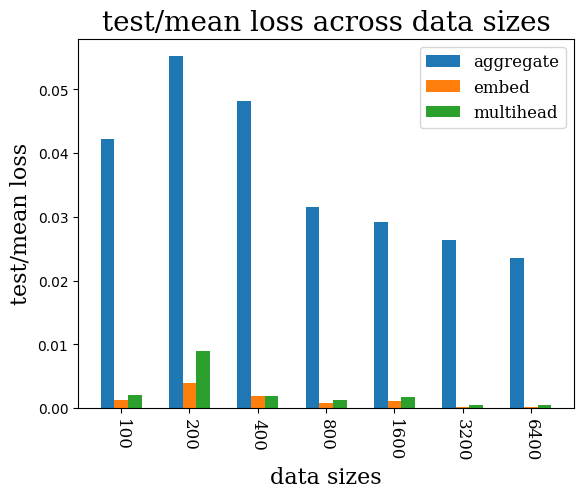

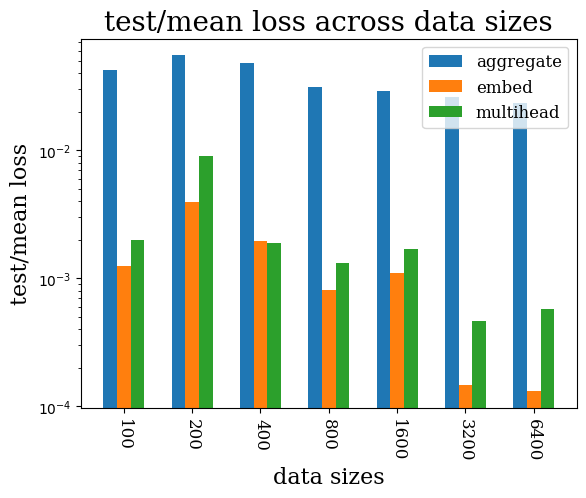

In [14]:
key = 'test/mean loss'
plot_bars_per_model_by_datasize(key)
# plt.savefig(f"figures/mean loss across data sizes")
plt.show()
plot_bars_per_model_by_datasize(key, logy=True)
# plt.savefig(f"figures/mean loss across data sizes logy")

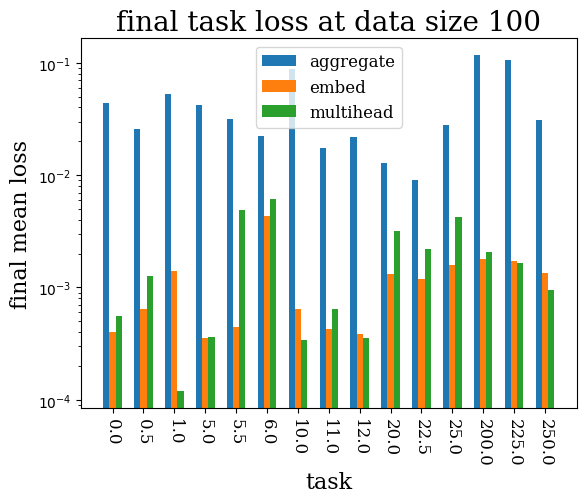

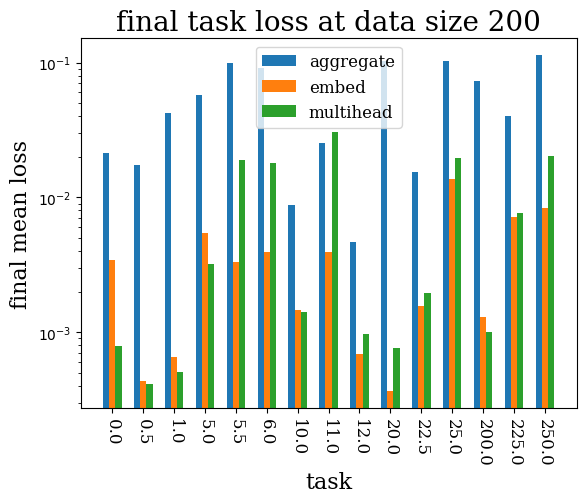

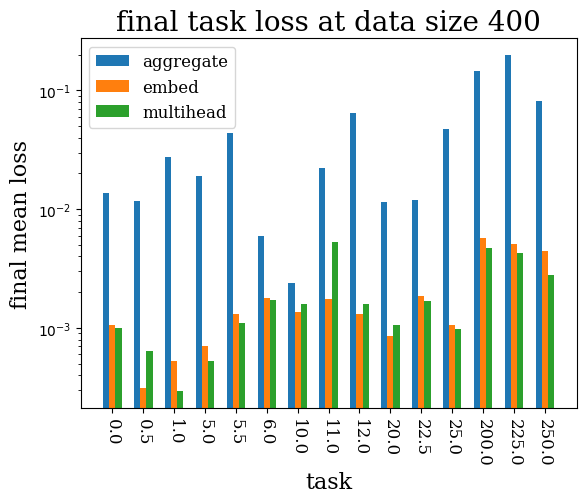

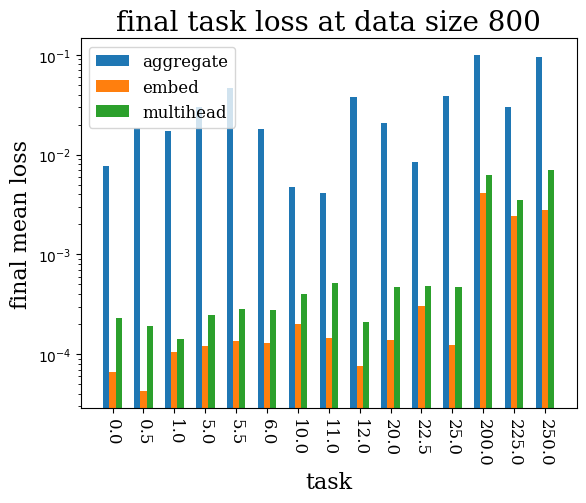

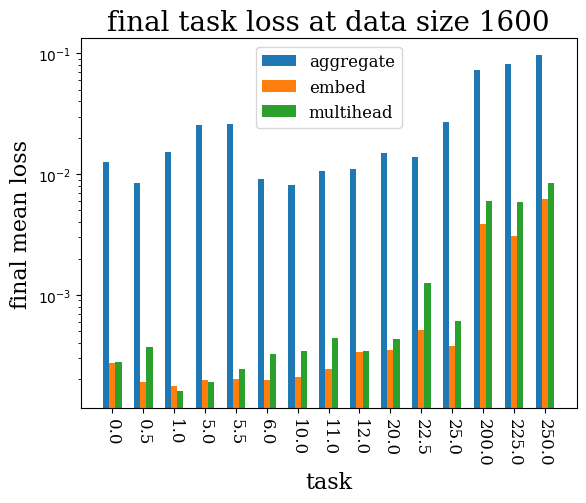

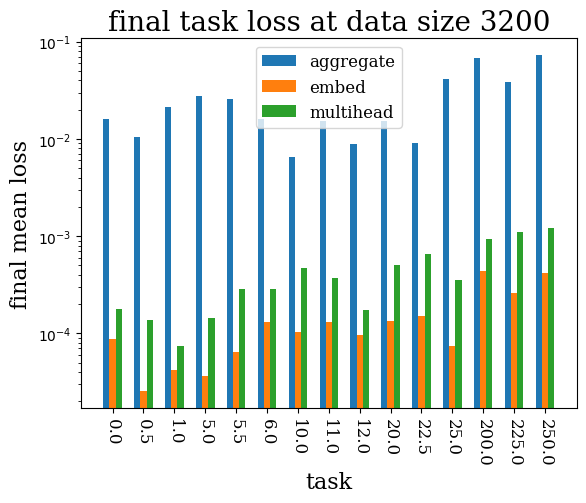

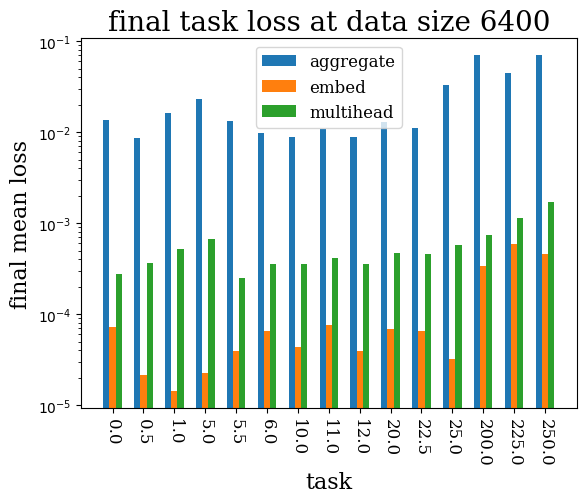

In [15]:
# task_model_meanloss_atsize_last = get_task_model_meanloss_atsize(size_idx=-1)
for size_idx, size in enumerate(data_sizes):
    plot_bars_per_model_by_task_atsize(size_idx=size_idx, logy=True)
    # plt.savefig(f"figures/final_task_losses_at_data_size_{size}")
    plt.show()

In [12]:
print(*ea.Tags()['scalars'], sep='\n')

train/mean loss
train/state_loss_across_tasks/state_element_0
train/state_loss_across_tasks/state_element_1
train/state_loss_across_tasks/state_element_2
train/task_losses/mean_loss
train/task_losses/task_0/state_element_0_task_0_loss
train/task_losses/task_0/state_element_1_task_0_loss
train/task_losses/task_0/state_element_2_task_0_loss
train/task_losses/task_1/state_element_0_task_1_loss
train/task_losses/task_1/state_element_1_task_1_loss
train/task_losses/task_1/state_element_2_task_1_loss
train/task_losses/task_2/state_element_0_task_2_loss
train/task_losses/task_2/state_element_1_task_2_loss
train/task_losses/task_2/state_element_2_task_2_loss
train/task_losses/task_3/state_element_0_task_3_loss
train/task_losses/task_3/state_element_1_task_3_loss
train/task_losses/task_3/state_element_2_task_3_loss
train/task_losses/task_4/state_element_0_task_4_loss
train/task_losses/task_4/state_element_1_task_4_loss
train/task_losses/task_4/state_element_2_task_4_loss
train/task_losses/task_

## Scratch

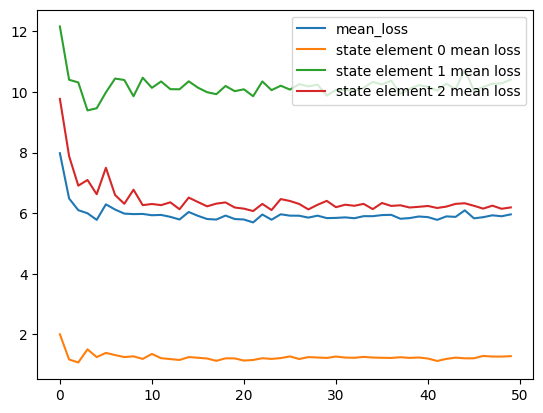

In [ ]:
steps, vals = get_steps_values(ea, f'test/mean loss')
plt.plot(vals, label='mean_loss')
# plt.ylim(0)


state_losses = []
for state_element in range(3):
    steps, vals = get_steps_values(ea, f'test/state element {state_element}/mean loss')
    plt.plot(vals, label=f'state element {state_element} mean loss')

plt.legend()

(0.0, 0.4041175429635511)

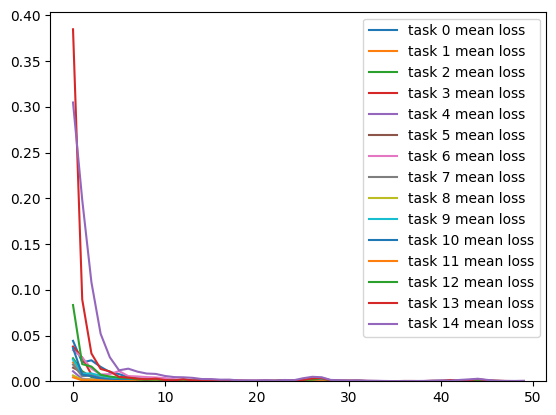

In [94]:
for task in range(15):
    state_losses = []
    for state_element in range(3):
        steps, vals = get_steps_values(ea, f'train/task losses/task_{task}/state element {state_element}')
        state_losses.append(vals)
    task_loss = np.mean(state_losses, axis=0)
    plt.plot(task_loss, label=f'task {task} mean loss')
plt.legend()
plt.ylim(0)

In [156]:
size_model_vals.shape, sizes, models
size_model_vals[:, 0]

array([ 6.47892618, 35.20837021, 10.3237505 ,  5.75037432,  4.65355587,
        3.80107617,  3.29164505,  4.0491333 ,  2.73472095,  3.15189743])

In [ ]:
plt.bar(x = 

Text(0.5, 1.0, 'title')

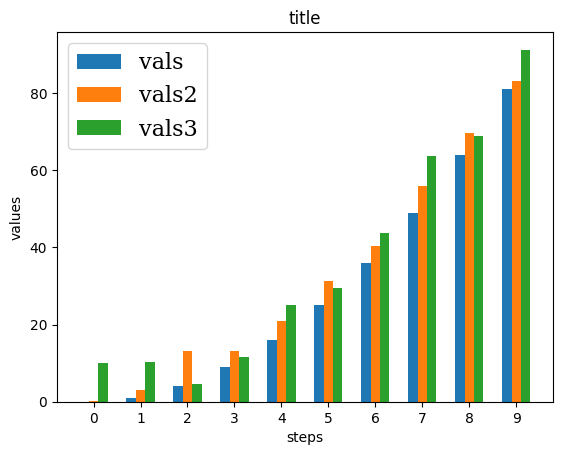

In [153]:
bar_width = 0.2
vals = np.arange(10)**2
vals2 = np.arange(10)**2 + np.random.random(vals.shape) * 10
vals3 = np.arange(10)**2 + np.random.random(vals.shape) * 20
steps = np.arange(len(vals))

plt.bar(steps + -1 * bar_width, vals, width=bar_width, label='vals')
plt.bar(steps + 0 * bar_width, vals2, width=bar_width, label='vals2')
plt.bar(steps + 1 * bar_width, vals3, width=bar_width, label='vals3')
plt.legend(prop=label_fontdict)

plt.xticks(ticks=steps, labels=steps);
plt.xlabel('steps')
plt.ylabel('values')
plt.title('title')

In [10]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from pathlib import Path

logdir = Path('/Users/puter/Documents/drl/roadrunner_refactor/trained_models/CassieHfield_noclock')
logdir /= 'cassie_noclock_heightmap_residual_mix_terrain_1/02-14-15-32'

event_acc = EventAccumulator(logdir.name)
event_acc.Reload()
# Show all tags in the log file
print(event_acc.Tags())

# E. g. get wall clock, number of steps and value for a scalar 'Accuracy'
# w_times, step_nums, vals = zip(*event_acc.Scalars('Accuracy'))

In [230]:
event_acc.Scalars('train')

KeyError: 'Key train was not found in Reservoir'

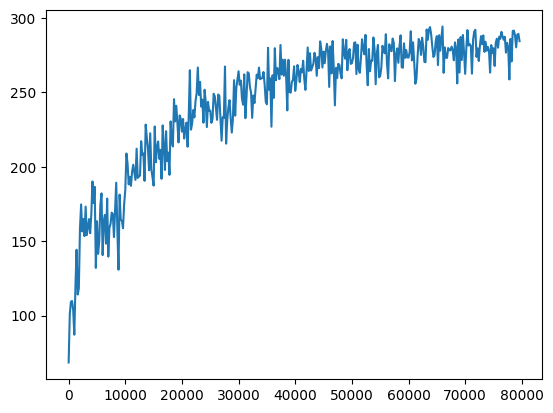

In [219]:
(steps, values) = zip(*map(lambda scalar: (scalar.step, scalar.value), event_acc.Scalars('Test/Return')))
plt.plot(steps, values)

# Gym run visualizer

In [44]:
env = gym.make("Pendulum-v1")#, render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    action = env.action_space.sample()  # this is where you would insert your policy
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        print(f"global_iter: {_}, terminated: {terminated}, truncated: {truncated}")
        observation, info = env.reset()

env.close()

global_iter: 199, terminated: False, truncated: True
global_iter: 399, terminated: False, truncated: True
global_iter: 599, terminated: False, truncated: True
global_iter: 799, terminated: False, truncated: True
global_iter: 999, terminated: False, truncated: True


### torch.utils.data.Dataset/DataLoader

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from dataset import CustomDataset, custom_collate_fn

# Dummy data (for demonstration purpose)
data = torch.randn(100, 2)  # 100 samples, each with 2 features

# Create an instance of your custom dataset
custom_dataset = CustomDataset(data)

# Create a DataLoader with dynamic trajectory sampling
batch_size = 10
shuffle = True
num_workers = 2
trajectory_sampling = True  # Set to True to sample trajectories, False for individual transitions

# Dynamically set trajectory sampling when creating DataLoader
dataloader = DataLoader(custom_dataset, 
                        batch_size=batch_size, 
                        shuffle=shuffle, 
                        num_workers=num_workers,
                        collate_fn=lambda batch: custom_collate_fn(batch, trajectory_sampling))

# Iterate over batches
for batch in dataloader:
    # Batch is a tuple containing input tensors
    inputs = batch
    if trajectory_sampling:
        print("Trajectory batch shape:", inputs.shape)  # shape of the batch when sampling trajectories
    else:
        print("Individual transition batch shape:", inputs.shape)  # shape of the batch when sampling individual transitions
    # Do whatever processing you need here


PicklingError: Can't pickle <function <lambda> at 0x1057f13a0>: attribute lookup <lambda> on __main__ failed

In [7]:
from mt_model_buffer import MT_Model_Buffer

buffer = MT_Model_Buffer()
for ep in range(10):
    state = np.random.rand(5)
    for step in range(100):
        action = np.random.rand(2)
        next_state = np.random.rand(5)
        done = np.random.random() < 1/100
        buffer.push(task=ep, state=state, action=action, next_state=next_state, done=done)
        if done: break
    buffer.end_trajectory()



TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Tensor'

In [126]:
torch.nn.Embedding(3, 2)(torch.tensor([0, 1, 2], dtype=float).to(int))

tensor([[ 0.8098, -0.3745],
        [-0.7476, -0.4974],
        [-0.7441, -0.2986]], grad_fn=<EmbeddingBackward0>)